<font color = red><b> To do list </b> </font>
<br>
The goal of this project is to learn the ins and outs of decision trees and random forests. Your task is to code the following from scratch:

A decision tree that uses Information Gain as split criterium and chi square as alternate termination rule.
Implement Information Gain with: (1) entropy, (2) gini index, (3) misclasification error
Implement a random forest based on your decision tree and any criteria of your choosing

You are allowed to use:

pandas to deal with the data
train_test_split or other data split methods from sklearn.model_selection
any visualization tool or analysis library to obtain insights from your results
scipy.stats.chi2.ppf
basic numpy or scipy (but not for the functions that you need to code from scratch)

Complete the following experiments:

Compare and contrast the trees built by IG with entropy, gini index, and misclassification error, in terms of their structural properties and accuracy. Include for example maximum depth, average depth, average accuracy, etc
Use chi-square as a termination rule with \alpha = 0.01, 0.05, 0.1, 0.25, 0.5, 0.9 compare and contrast the resulting trees


Instal Packages

<font color = 'Blue'><b> -------- Behnoud start -------- </b></font>

In [2]:
print ('sdf')

sdf


Import Packages<br>


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import chi2_contingency
print ('test')

test


Parameter setting
1. Folder path
2. Metadat

In [66]:
root_folder = 'HM1/'
train_file = 'train.csv'
test_file = 'test.csv'
Index = 'TransactionID'
Target = 'isFraud'

Read data

In [69]:
train_1 = pd.read_csv(root_folder+train_file)
test_1 = pd.read_csv(root_folder + test_file)
#print (train.columns)
train_1.shape

(472432, 27)

In [70]:
shuffled_indices = list(train_1.index)
random.shuffle(shuffled_indices)
train = train_1.reindex(shuffled_indices)
print(train.head())

        TransactionID ProductCD  card1  card2  card3       card4  card5  \
217202         217203         W  13249  111.0  150.0        visa  226.0   
55838           55839         W   6465  555.0  150.0        visa  226.0   
41717           41718         W   7815  161.0  150.0  mastercard  117.0   
331840         331841         W   9364  225.0  150.0  mastercard  126.0   
384444         384445         R   3602  119.0  150.0        visa  195.0   

         card6  addr1 addr2  ...   C6   C7   C8   C9  C10  C11  C12   C13  \
217202   debit  264.0  87.0  ...  2.0  0.0  0.0  2.0  0.0  2.0  0.0   3.0   
55838    debit  469.0  87.0  ...  1.0  0.0  0.0  1.0  0.0  2.0  0.0  12.0   
41717    debit  203.0  87.0  ...  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0   
331840   debit  181.0  87.0  ...  1.0  0.0  0.0  1.0  0.0  1.0  0.0   6.0   
384444  credit  387.0  87.0  ...  1.0  0.0  2.0  0.0  1.0  1.0  0.0   1.0   

        C14  isFraud  
217202  2.0        0  
55838   1.0        0  
41717   1.0      

Basic statistics

C:\Users\behno\AppData\Local\Temp\ipykernel_6284\1996311888.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax  = plt.subplots(figsize= (5,3))


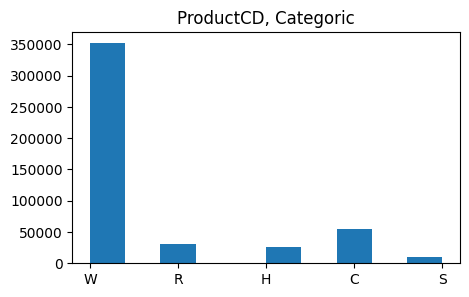

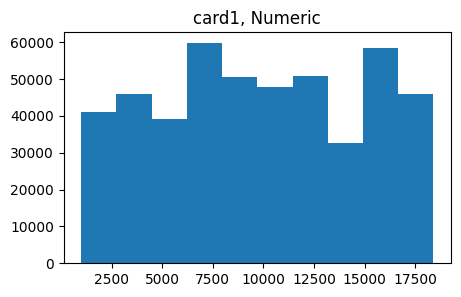

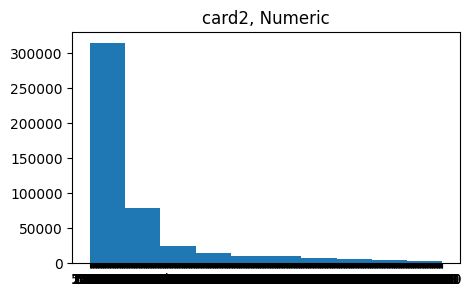

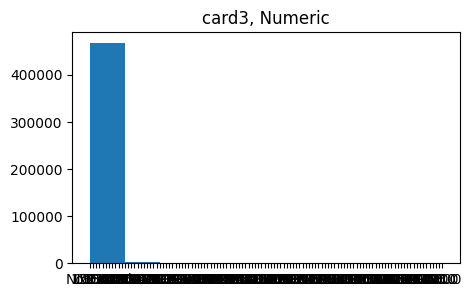

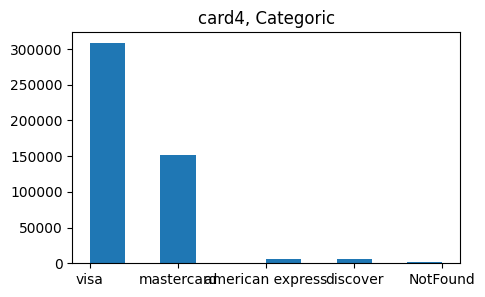

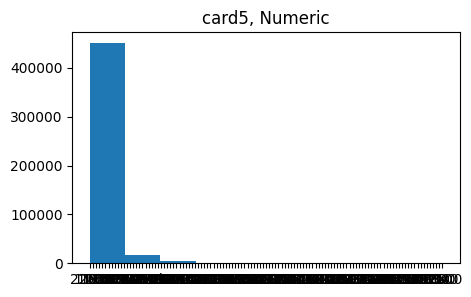

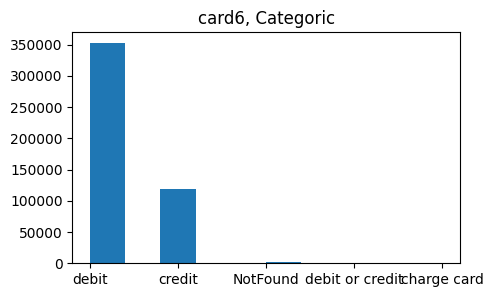

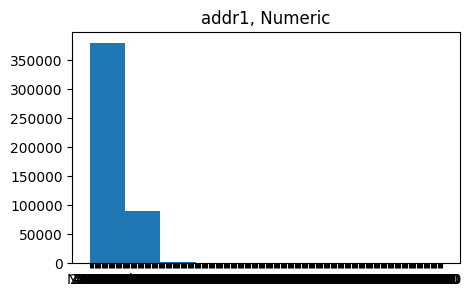

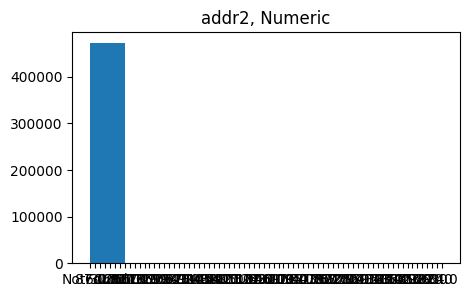

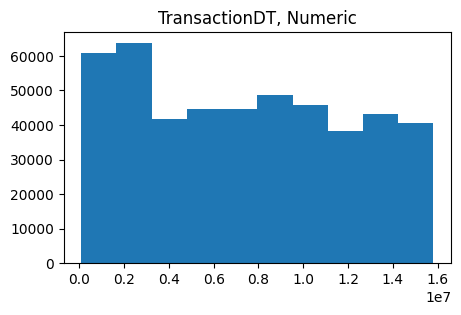

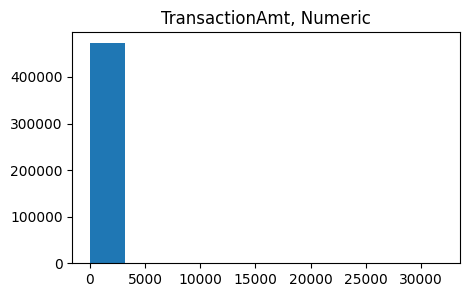

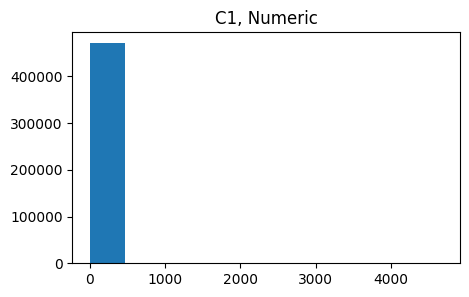

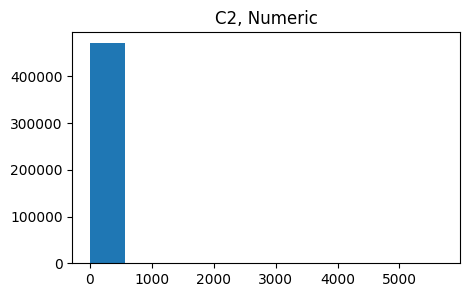

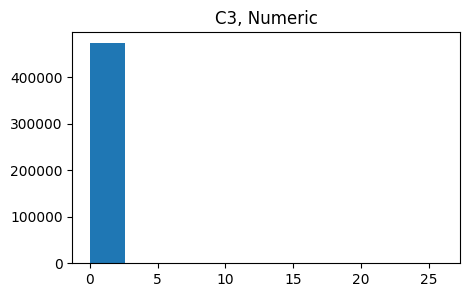

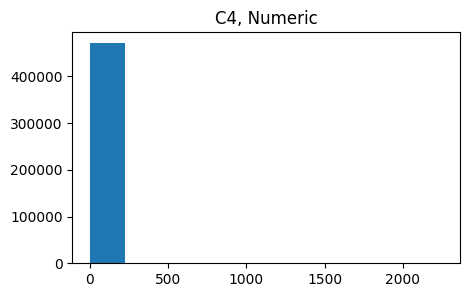

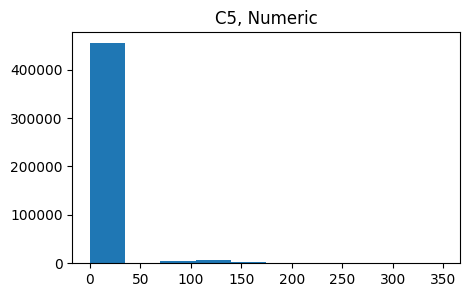

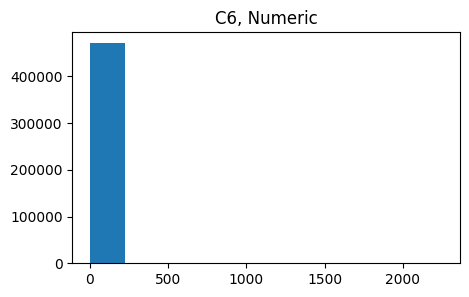

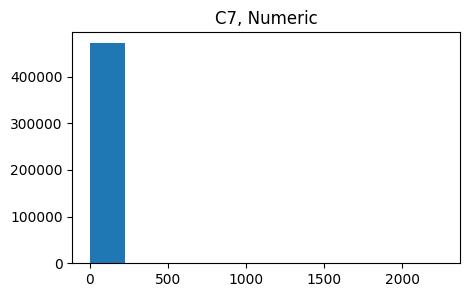

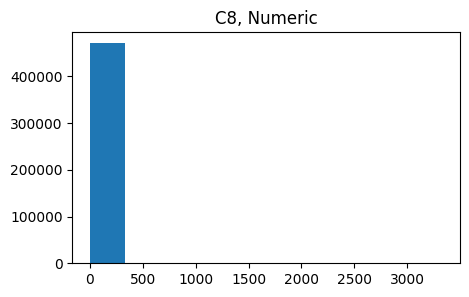

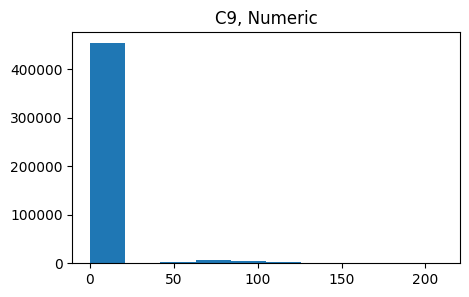

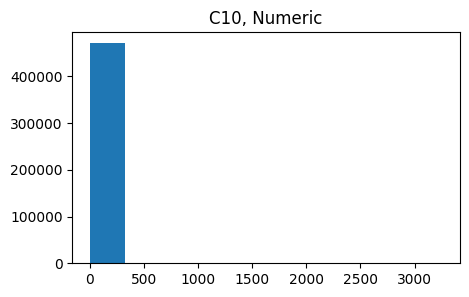

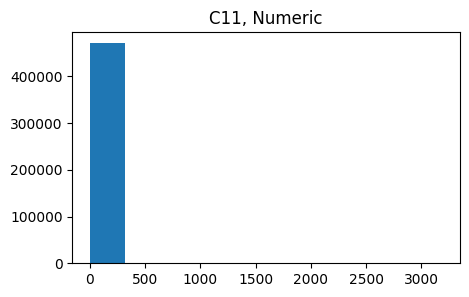

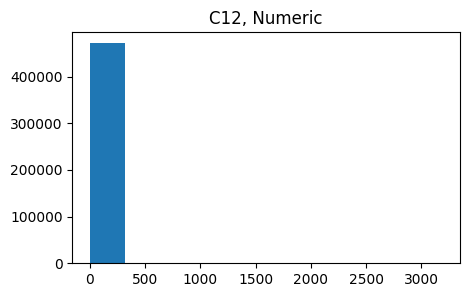

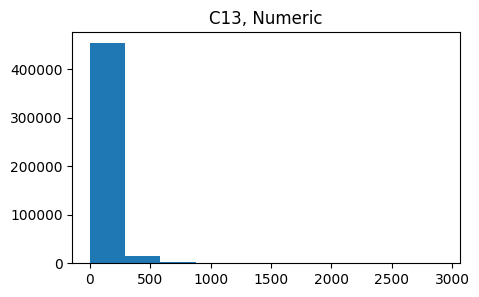

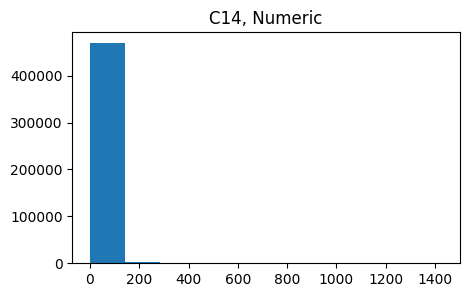

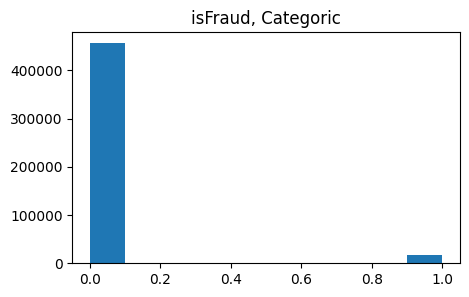

In [71]:
size = train.shape
Columns = train.columns.values
Columns = Columns[Columns != Index]
Categoric_features = []
Numeric_features = []
for i in Columns:
  fig, ax  = plt.subplots(figsize= (5,3))
  plt.hist(train[i])
  unique = np.unique(train[i])
  if len(unique) > 20:
    identify = 'Numeric'
    Numeric_features.append(i)
  else:
    identify = 'Categoric'
    Categoric_features.append(i)
  plt.title(f"{i:}, {identify}")

In [72]:
print (Numeric_features)
print (Categoric_features)

['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'TransactionDT', 'TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
['ProductCD', 'card4', 'card6', 'isFraud']


In [73]:
train.shape

(472432, 27)

Information gain function

In [26]:
train.head()
tmp = train.sort_values(by = 'card1')
tmp.head()

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
19678,19679,W,1004,583.0,150.0,visa,226.0,credit,325.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
45755,45756,H,1011,543.0,150.0,mastercard,224.0,debit,337.0,87.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
14432,14433,W,1013,555.0,150.0,visa,226.0,debit,203.0,87.0,...,149.0,0.0,0.0,134.0,0.0,132.0,0.0,542.0,168.0,0.0
22191,22192,W,1013,555.0,150.0,visa,226.0,debit,203.0,87.0,...,151.0,0.0,0.0,134.0,0.0,133.0,0.0,543.0,169.0,0.0
18297,18298,W,1013,555.0,150.0,visa,226.0,debit,203.0,87.0,...,209.0,0.0,0.0,194.0,0.0,217.0,0.0,523.0,218.0,0.0


In [74]:
def IG(Input_Dataframe, Split_feature, IG_methods): #IG_methods = 'Gini'/ 'Entropy' / 'MisEr'
  length = Input_Dataframe.shape[0]
  Fraud_arr = Input_Dataframe[Target]
  print ('Pass line 3')
  # propability of Fraud and not Fraud
  P_isF = len(Fraud_arr[Fraud_arr == 1])/length
  P_notF = 1-P_isF
  Gini_root = 1 - np.power(P_isF,2)  - np.power(P_notF,2)
  Gini_leaves = [] #Gini index of each leaves
  Prop_leaves = [] #Propotion of each leaves
  print ('Pass line 10')
  if Split_feature in Categoric_features:
    Feature_classes = np.unique(Input_Dataframe[Split_feature])
    if IG_methods == 'Gini':
      print ('Pass line 15')
      for i in Feature_classes:
        Sub_df = Input_Dataframe[Input_Dataframe[Split_feature] == i]
        Sub_len = len(Sub_df)
        Sub_P_isF = len(Sub_df[Sub_df[Target] == 1])/Sub_len
        Sub_P_notF = 1-Sub_P_isF
        Gini_leaves.append(1 - np.power(Sub_P_isF,2)  - np.power(Sub_P_notF,2))
        Prop_leaves.append(Sub_len/length)
    elif Split_feature in Numeric_features:
      Sort_Inupt = Input_Dataframe.sort(by = Split_feature)

  Gini_root = np.array(Gini_root)
  Prop_leaves = np.array(Prop_leaves)
  IG_feature = Gini_root - np.matmul(Gini_leaves,Prop_leaves.T)

  return IG_feature

In [ ]:
8/25 - (1-50/64) * 8/10

0.14500000000000002

In [76]:
test = train[0:10]
print(IG(test,'ProductCD','Gini'))
test

Pass line 3
Pass line 10
Pass line 15
0.17999999999999994


,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
217202,217203,W,13249,111.0,150.0,visa,226.0,debit,264.0,87.0,...,2.0,0.0,0.0,2.0,0.0,2.0,0.0,3.0,2.0,0
55838,55839,W,6465,555.0,150.0,visa,226.0,debit,469.0,87.0,...,1.0,0.0,0.0,1.0,0.0,2.0,0.0,12.0,1.0,0
41717,41718,W,7815,161.0,150.0,mastercard,117.0,debit,203.0,87.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0
331840,331841,W,9364,225.0,150.0,mastercard,126.0,debit,181.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,2.0,0
384444,384445,R,3602,119.0,150.0,visa,195.0,credit,387.0,87.0,...,1.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0
60529,60530,H,10547,115.0,150.0,visa,166.0,debit,299.0,87.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
168892,168893,W,5901,583.0,150.0,visa,226.0,credit,315.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,15.0,1.0,0
285137,285138,W,16972,174.0,150.0,visa,226.0,debit,269.0,87.0,...,1.0,0.0,0.0,2.0,0.0,1.0,0.0,11.0,1.0,0
198052,198053,W,11106,100.0,150.0,visa,226.0,credit,204.0,87.0,...,3.0,0.0,0.0,4.0,0.0,5.0,0.0,9.0,7.0,0
45262,45263,C,14182,562.0,150.0,mastercard,102.0,credit,NotFound,NotFound,...,3.0,3.0,2.0,0.0,4.0,2.0,2.0,2.0,2.0,1


<font color = red> **Experiment1: </font>** with only 100 random rows

Load data

In [ ]:
# shuffle the train data
train = train.sample(frac = 1)
Exp1_train = train[0:100]
Exp1_train.tail()

,TransactionID,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,isFraud
3475,3476,W,15497,490.0,150.0,visa,226.0,debit,220.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
3096,3097,W,17188,321.0,150.0,visa,226.0,debit,310.0,87.0,...,5.0,0.0,0.0,4.0,0.0,5.0,0.0,29.0,7.0,0
41412,41413,W,12389,532.0,150.0,mastercard,137.0,credit,485.0,87.0,...,17.0,0.0,0.0,12.0,0.0,11.0,0.0,77.0,18.0,0
252732,252733,W,1214,174.0,150.0,visa,226.0,credit,181.0,87.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,0
429720,429721,C,11436,555.0,150.0,visa,226.0,credit,NotFound,NotFound,...,16.0,16.0,33.0,0.0,17.0,20.0,20.0,2.0,2.0,1


Gini index for the Root node

In [78]:
for i in Columns:
  if i in Categoric_features:
    print("Categorical: " + i)

  if i in Numeric_features:
    print("Numerical: " + i)




Categorical: ProductCD
Numerical: card1
Numerical: card2
Numerical: card3
Categorical: card4
Numerical: card5
Categorical: card6
Numerical: addr1
Numerical: addr2
Numerical: TransactionDT
Numerical: TransactionAmt
Numerical: C1
Numerical: C2
Numerical: C3
Numerical: C4
Numerical: C5
Numerical: C6
Numerical: C7
Numerical: C8
Numerical: C9
Numerical: C10
Numerical: C11
Numerical: C12
Numerical: C13
Numerical: C14
Categorical: isFraud


<font color = 'Blue'><b> -------- Behnoud end -------- </b></font>